
# Análise Exploratória - CSNA3.SA (Companhia Siderúrgica Nacional)

**Objetivo:** Realizar uma análise exploratória dos dados da ação CSNA3.SA, preparando a base para a criação de modelos de Deep Learning para previsão de tendências de Compra/Venda.

**Metodologia:**
1.  Carregamento e inspeção inicial dos dados de treino e teste.
2.  Engenharia de features, incluindo indicadores técnicos como Médias Móveis, MACD, RSI, ROC e Bandas de Bollinger.
3.  Tratamento de valores ausentes.
4.  Visualização dos dados, distribuições e correlações.
5.  Análise da variável alvo (`signal`).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os

# Configurações de visualização
plt.style.use('fivethirtyeight')
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)
# Configura tamanho padrão para os gráficos
plt.rcParams['figure.figsize'] = [15, 7]


## 1. Carregamento dos Dados

Carregamos os arquivos `treino.csv` e `teste.csv` específicos para a ação CSNA3.SA.


In [2]:
# Define o ticker e o diretório dos dados DENTRO desta célula
STOCK_TICKER = "CSNA3.SA"
STOCK_NAME = "Companhia Siderúrgica Nacional" # Nome para usar nos títulos/textos
DATA_DIR = os.path.join('../data', STOCK_TICKER)
TRAIN_PATH = os.path.join(DATA_DIR, 'treino.csv')
TEST_PATH = os.path.join(DATA_DIR, 'teste.csv')

print(f"Verificando dados para: {STOCK_TICKER}")
print(f"Diretório de dados: {DATA_DIR}")
print(f"Caminho Treino: {TRAIN_PATH}")
print(f"Caminho Teste: {TEST_PATH}")


# Verifica se os diretórios e arquivos existem
if not os.path.exists(DATA_DIR):
    print(f"ERRO: Diretório de dados não encontrado em '{DATA_DIR}'")
elif not os.path.exists(TRAIN_PATH):
    print(f"ERRO: Arquivo de treino não encontrado em '{TRAIN_PATH}'")
elif not os.path.exists(TEST_PATH):
    print(f"ERRO: Arquivo de teste não encontrado em '{TEST_PATH}'")
else:
    try:
        df_train_raw = pd.read_csv(TRAIN_PATH, index_col='Date', parse_dates=True)
        df_test_raw = pd.read_csv(TEST_PATH, index_col='Date', parse_dates=True)
        print(f"Dados de treino ({STOCK_TICKER}) carregados. Shape: {df_train_raw.shape}")
        print(f"Dados de teste ({STOCK_TICKER}) carregados. Shape: {df_test_raw.shape}")

        # Remove a coluna 'Unnamed: 0' se existir
        if 'Unnamed: 0' in df_train_raw.columns:
            df_train_raw = df_train_raw.drop(columns=['Unnamed: 0'])
        if 'Unnamed: 0' in df_test_raw.columns:
            df_test_raw = df_test_raw.drop(columns=['Unnamed: 0'])

        print("\nColunas disponíveis:", df_train_raw.columns.tolist())

    except Exception as e:
        print(f"Erro ao carregar os dados para {STOCK_TICKER}: {e}")

# Exibe as primeiras linhas do treino para verificação
# Usa 'locals()' para verificar se a variável foi definida DENTRO do escopo da célula
if 'df_train_raw' in locals():
    print("\n--- Amostra Dados Treino ---")
    print(df_train_raw.head())
else:
    print("\nNão foi possível carregar os dados de treino.")

Verificando dados para: CSNA3.SA
Diretório de dados: ../data/CSNA3.SA
Caminho Treino: ../data/CSNA3.SA/treino.csv
Caminho Teste: ../data/CSNA3.SA/teste.csv
Dados de treino (CSNA3.SA) carregados. Shape: (4743, 19)
Dados de teste (CSNA3.SA) carregados. Shape: (1186, 19)

Colunas disponíveis: ['Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

--- Amostra Dados Treino ---
               Close  Smoothed_Close  Label  Past_1_Days_Close  \
Date                                                             
2000-01-24  1.409986        1.588954     -1           1.375888   
2000-01-26  1.398052        1.569864     -1           1.409986   
2000-01-27  1.375888        1.550466     -1           1.3


## 2. Inspeção Inicial dos Dados

Realizamos uma verificação básica dos dados carregados:
* Tipos de dados das colunas.
* Presença de valores ausentes (NaNs).
* Estatísticas descritivas básicas.


In [3]:
# Verifica se as variáveis existem no escopo local da célula
if 'df_train_raw' in locals() and 'df_test_raw' in locals():
    print("--- Informações Dataset Treino ---")
    df_train_raw.info()
    print("\n--- Valores Ausentes (Treino) ---")
    print(df_train_raw.isnull().sum())
    print("\n--- Estatísticas Descritivas (Treino) ---")
    print(df_train_raw.describe())

    print("\n" + "="*50 + "\n") # Separador

    print("--- Informações Dataset Teste ---")
    df_test_raw.info()
    print("\n--- Valores Ausentes (Teste) ---")
    print(df_test_raw.isnull().sum())
    print("\n--- Estatísticas Descritivas (Teste) ---")
    print(df_test_raw.describe())
else:
    print("DataFrames df_train_raw ou df_test_raw não definidos nesta célula.")

--- Informações Dataset Treino ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4743 entries, 2000-01-24 to 2019-03-22
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               4743 non-null   float64
 1   Smoothed_Close      4743 non-null   float64
 2   Label               4743 non-null   int64  
 3   Past_1_Days_Close   4743 non-null   float64
 4   Past_2_Days_Close   4743 non-null   float64
 5   Past_3_Days_Close   4743 non-null   float64
 6   Past_4_Days_Close   4743 non-null   float64
 7   Past_5_Days_Close   4743 non-null   float64
 8   Past_6_Days_Close   4743 non-null   float64
 9   Past_7_Days_Close   4743 non-null   float64
 10  Past_8_Days_Close   4743 non-null   float64
 11  Past_9_Days_Close   4743 non-null   float64
 12  Past_10_Days_Close  4743 non-null   float64
 13  Past_11_Days_Close  4743 non-null   float64
 14  Past_12_Days_Close  4743 non-null   float64
 15  Pa


## 3. Engenharia de Features e Definição do Alvo

Criamos novas features a partir dos dados existentes e definimos nossa variável alvo.

**Features Criadas:**
* `daily_return`: Variação percentual diária do preço de fechamento.
* Médias Móveis (SMA, EMA): Para identificar tendências de curto e longo prazo.
* MACD: Indicador de momentum e tendência.
* RSI: Oscilador para identificar condições de sobrecompra/sobrevenda.
* ROC: Taxa de variação do preço.
* Bandas de Bollinger: Indicador de volatilidade e níveis relativos de preço.
* `return_Past_X_Days_Close`: Retorno em relação a dias anteriores.

**Variável Alvo:**
* `signal`: Convertemos a coluna `Label` (+1/-1) para um formato binário (1/0).


In [4]:
def calculate_features_and_target_eda(df):
    """
    Calcula indicadores técnicos (incluindo BBands) e a variável alvo 'signal'.
    Retorna cópia do DataFrame.
    """
    df_copy = df.copy(); price_col = 'Close'
    print(f"Processando DataFrame com {df_copy.shape[0]} linhas.")

    if price_col not in df_copy.columns: raise ValueError(f"Coluna '{price_col}' não encontrada.")
    if 'Label' not in df_copy.columns: raise ValueError("Coluna 'Label' (alvo) não encontrada.")

    # a) Indicadores Técnicos
    print("Calculando indicadores...")
    df_copy['daily_return'] = df_copy[price_col].pct_change() * 100
    for window in [5, 10, 20, 50]: df_copy[f'sma_{window}'] = df_copy[price_col].rolling(window=window, min_periods=1).mean()
    df_copy['ema_12'] = df_copy[price_col].ewm(span=12, adjust=False).mean(); df_copy['ema_26'] = df_copy[price_col].ewm(span=26, adjust=False).mean()
    df_copy['macd'] = df_copy['ema_12'] - df_copy['ema_26']; df_copy['macd_signal'] = df_copy['macd'].ewm(span=9, adjust=False).mean(); df_copy['macd_hist'] = df_copy['macd'] - df_copy['macd_signal']
    delta = df_copy[price_col].diff(); gain = delta.where(delta > 0, 0).fillna(0); loss = -delta.where(delta < 0, 0).fillna(0)
    avg_gain = gain.ewm(com=14 - 1, min_periods=14).mean(); avg_loss = loss.ewm(com=14 - 1, min_periods=14).mean()
    rs = avg_gain / avg_loss; df_copy['rsi'] = 100 - (100 / (1 + rs)); df_copy['rsi'] = df_copy['rsi'].fillna(50) # Preenche NaNs iniciais
    for window in [5, 10, 20]: df_copy[f'roc_{window}'] = df_copy[price_col].pct_change(periods=window) * 100

    # Bandas de Bollinger
    bb_window = 20; bb_std_dev = 2
    if f'sma_{bb_window}' not in df_copy.columns: df_copy[f'sma_{bb_window}'] = df_copy[price_col].rolling(window=bb_window, min_periods=1).mean()
    # Calcula std dev ANTES de dropar NaNs que ela pode gerar
    std_dev_temp = df_copy[price_col].rolling(window=bb_window, min_periods=1).std()
    df_copy['bollinger_high'] = df_copy[f'sma_{bb_window}'] + (bb_std_dev * std_dev_temp)
    df_copy['bollinger_low'] = df_copy[f'sma_{bb_window}'] - (bb_std_dev * std_dev_temp)
    # Não precisamos mais da coluna std_dev_temp

    # b) Features de Retorno Histórico
    past_cols = [col for col in df_copy.columns if col.startswith('Past_') and col.endswith('_Close')]
    if past_cols: # Só calcula se as colunas existirem
        print("Calculando features de retorno histórico...")
        for col in past_cols:
            try: df_copy[f'return_{col}'] = (df_copy[price_col] / df_copy[col] - 1) * 100; df_copy[f'return_{col}'] = df_copy[f'return_{col}'].replace([np.inf, -np.inf], np.nan)
            except Exception as e: pass
    else:
        print("Colunas 'Past_X_Days_Close' não encontradas, features de retorno histórico não calculadas.")


    # c) Variável Alvo
    print("Mapeando 'Label' para 'signal'...")
    if df_copy['Label'].isin([1, -1]).all(): df_copy['signal'] = df_copy['Label'].map({1: 1, -1: 0})
    elif df_copy['Label'].isin([1, 0]).all(): df_copy['signal'] = df_copy['Label']
    else: raise ValueError(f"Valores inesperados na coluna 'Label': {df_copy['Label'].unique()}.")
    if 'Label' in df_copy.columns: df_copy = df_copy.drop(columns=['Label'])

    print("Engenharia de features concluída.")
    return df_copy

# Aplicar a função (se os dataframes foram carregados na célula anterior)
if 'df_train_raw' in locals() and 'df_test_raw' in locals():
    print("\n--- Processando Treino ---")
    df_train = calculate_features_and_target_eda(df_train_raw)
    print("\n--- Processando Teste ---")
    df_test = calculate_features_and_target_eda(df_test_raw)

    # Exibir amostra dos dados processados
    print("\n--- Amostra Dados Treino Processados ---")
    print(df_train.head())
    print("\n--- Colunas após processamento ---")
    print(df_train.columns.tolist())
else:
    print("\nDataFrames não carregados na célula anterior. Engenharia de features não realizada.")


--- Processando Treino ---
Processando DataFrame com 4743 linhas.
Calculando indicadores...
Calculando features de retorno histórico...
Mapeando 'Label' para 'signal'...
Engenharia de features concluída.

--- Processando Teste ---
Processando DataFrame com 1186 linhas.
Calculando indicadores...
Calculando features de retorno histórico...
Mapeando 'Label' para 'signal'...
Engenharia de features concluída.

--- Amostra Dados Treino Processados ---
               Close  Smoothed_Close  Past_1_Days_Close  Past_2_Days_Close  \
Date                                                                         
2000-01-24  1.409986        1.588954           1.375888           1.478184   
2000-01-26  1.398052        1.569864           1.409986           1.375888   
2000-01-27  1.375888        1.550466           1.398052           1.409986   
2000-01-28  1.363953        1.531815           1.375888           1.398052   
2000-01-31  1.329854        1.511619           1.363953           1.375888   

  


## 4. Tratamento de Valores Ausentes (NaNs) Pós-Cálculo

Após calcular os indicadores, especialmente aqueles com janelas maiores (SMA 50, BBands), teremos valores NaN no início da série. Removemos essas linhas para garantir dados completos para a análise e modelagem.


In [5]:
if 'df_train' in locals() and 'df_test' in locals():
    print("Tratando NaNs após cálculo de features...")
    initial_train_rows = len(df_train); initial_test_rows = len(df_test)

    # Preencher NaNs específicos das features de retorno histórico com 0 (se existirem)
    return_past_cols = [col for col in df_train.columns if col.startswith('return_Past_')]
    if return_past_cols:
        df_train[return_past_cols] = df_train[return_past_cols].fillna(0)
        df_test[return_past_cols] = df_test[return_past_cols].fillna(0)

    # Remover linhas com qualquer NaN restante
    # É importante fazer isso DEPOIS de calcular todos os indicadores
    df_train.dropna(inplace=True)
    df_test.dropna(inplace=True)

    print(f"Linhas removidas do treino: {initial_train_rows - len(df_train)}")
    print(f"Linhas removidas do teste: {initial_test_rows - len(df_test)}")
    print(f"Shape treino final: {df_train.shape}")
    print(f"Shape teste final: {df_test.shape}")

    if df_train.empty or df_test.empty:
         print("ALERTA: Um dos DataFrames ficou vazio após remover NaNs!")
    else:
        # Garantir que 'signal' seja inteiro
        df_train['signal'] = df_train['signal'].astype(int)
        df_test['signal'] = df_test['signal'].astype(int)
        print("\nVerificação final de NaNs (Treino):", df_train.isna().sum().sum())
        print("Verificação final de NaNs (Teste):", df_test.isna().sum().sum())
else:
    print("\nDataFrames df_train ou df_test não definidos nesta célula. Tratamento de NaNs não realizado.")

Tratando NaNs após cálculo de features...
Linhas removidas do treino: 20
Linhas removidas do teste: 20
Shape treino final: (4723, 49)
Shape teste final: (1166, 49)

Verificação final de NaNs (Treino): 0
Verificação final de NaNs (Teste): 0



## 5. Análise Visual dos Dados

Visualizamos os dados e as features criadas para entender melhor seu comportamento.

* **Preço de Fechamento:** Observamos a evolução do preço ao longo do tempo.
* **Retorno Diário:** Analisamos a distribuição dos retornos.
* **Volatilidade Móvel:** Visualizamos a volatilidade do preço em janelas móveis.
* **Indicadores Técnicos:** Plotamos alguns indicadores chave (Médias Móveis, Bandas de Bollinger, MACD, RSI) sobre o gráfico de preço.


Gerando visualizações...


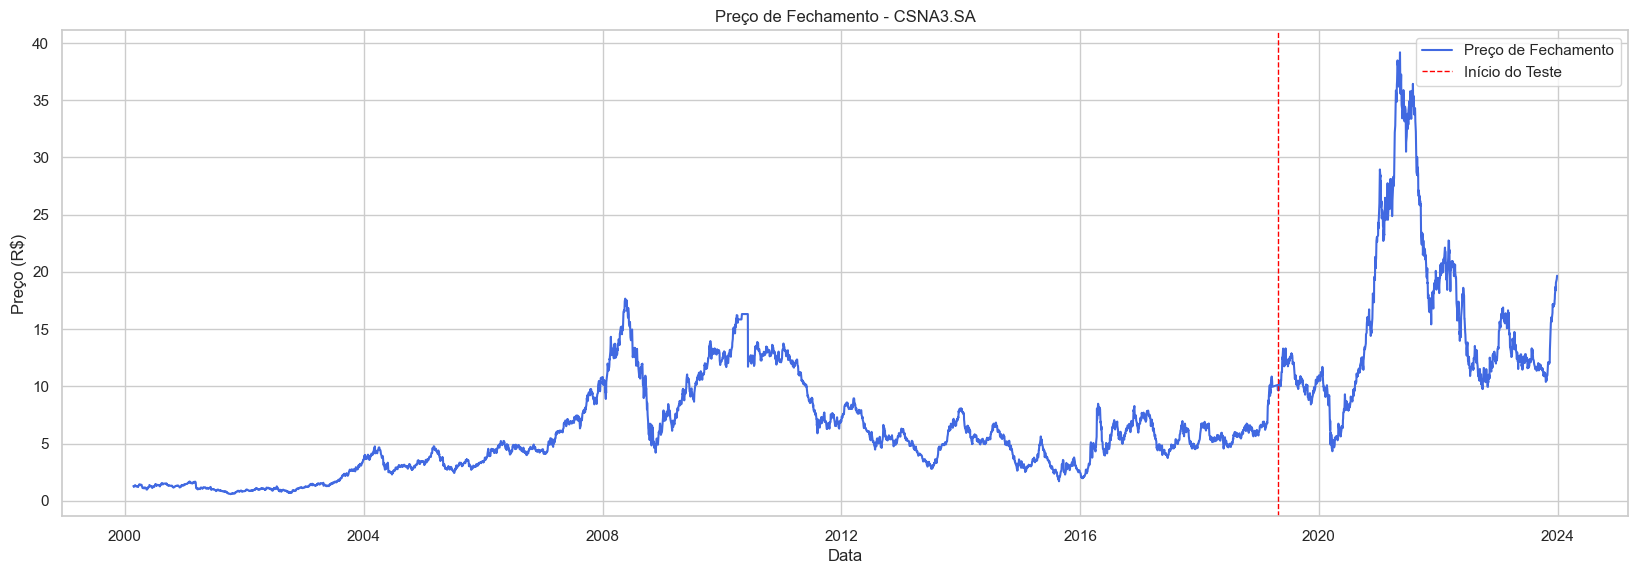

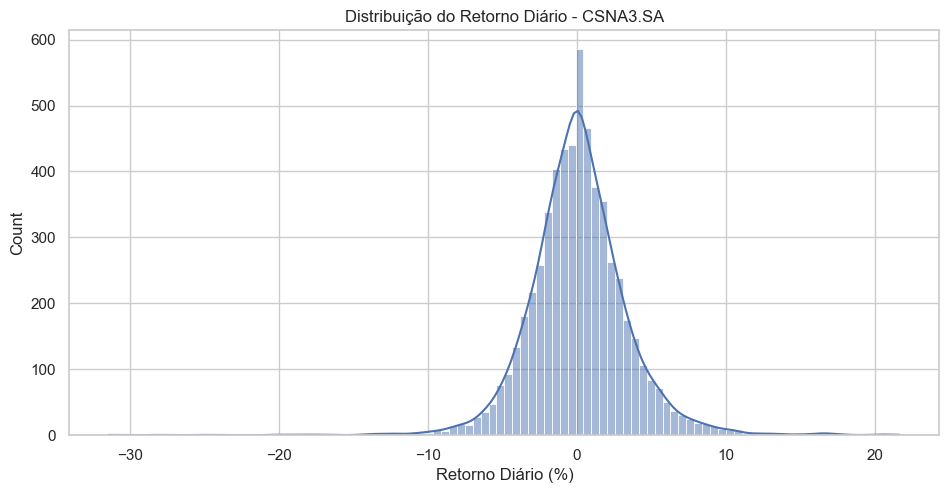

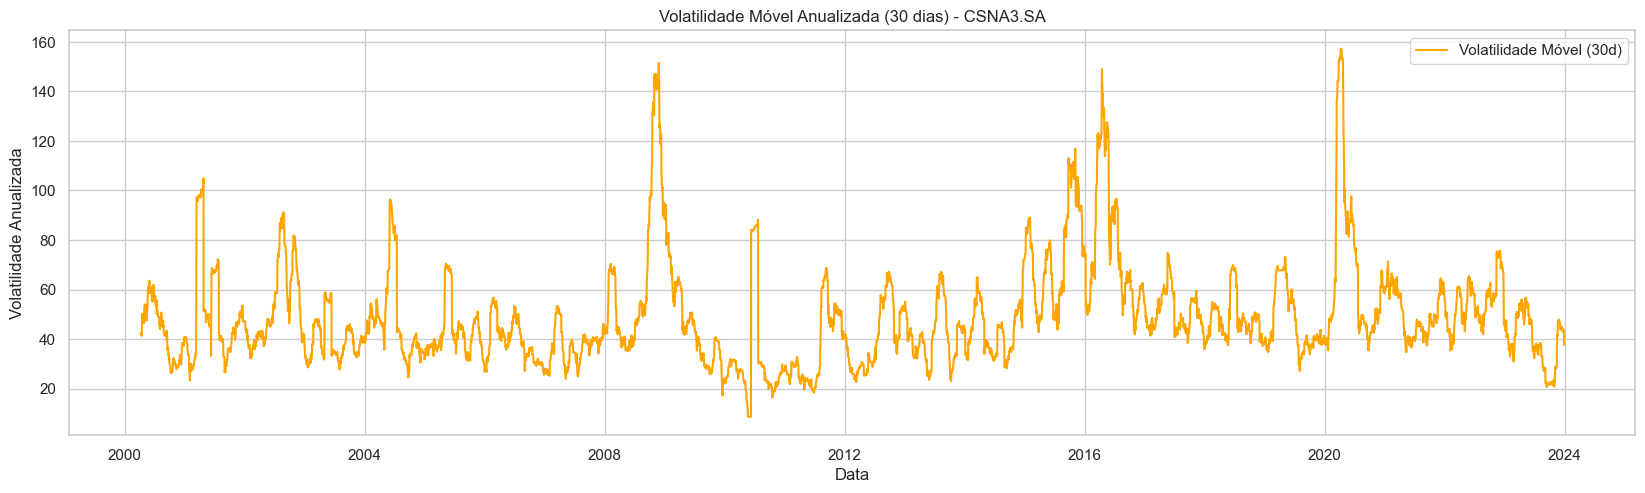


Plotando Preço com Médias Móveis e Bandas de Bollinger (Período de Teste)...


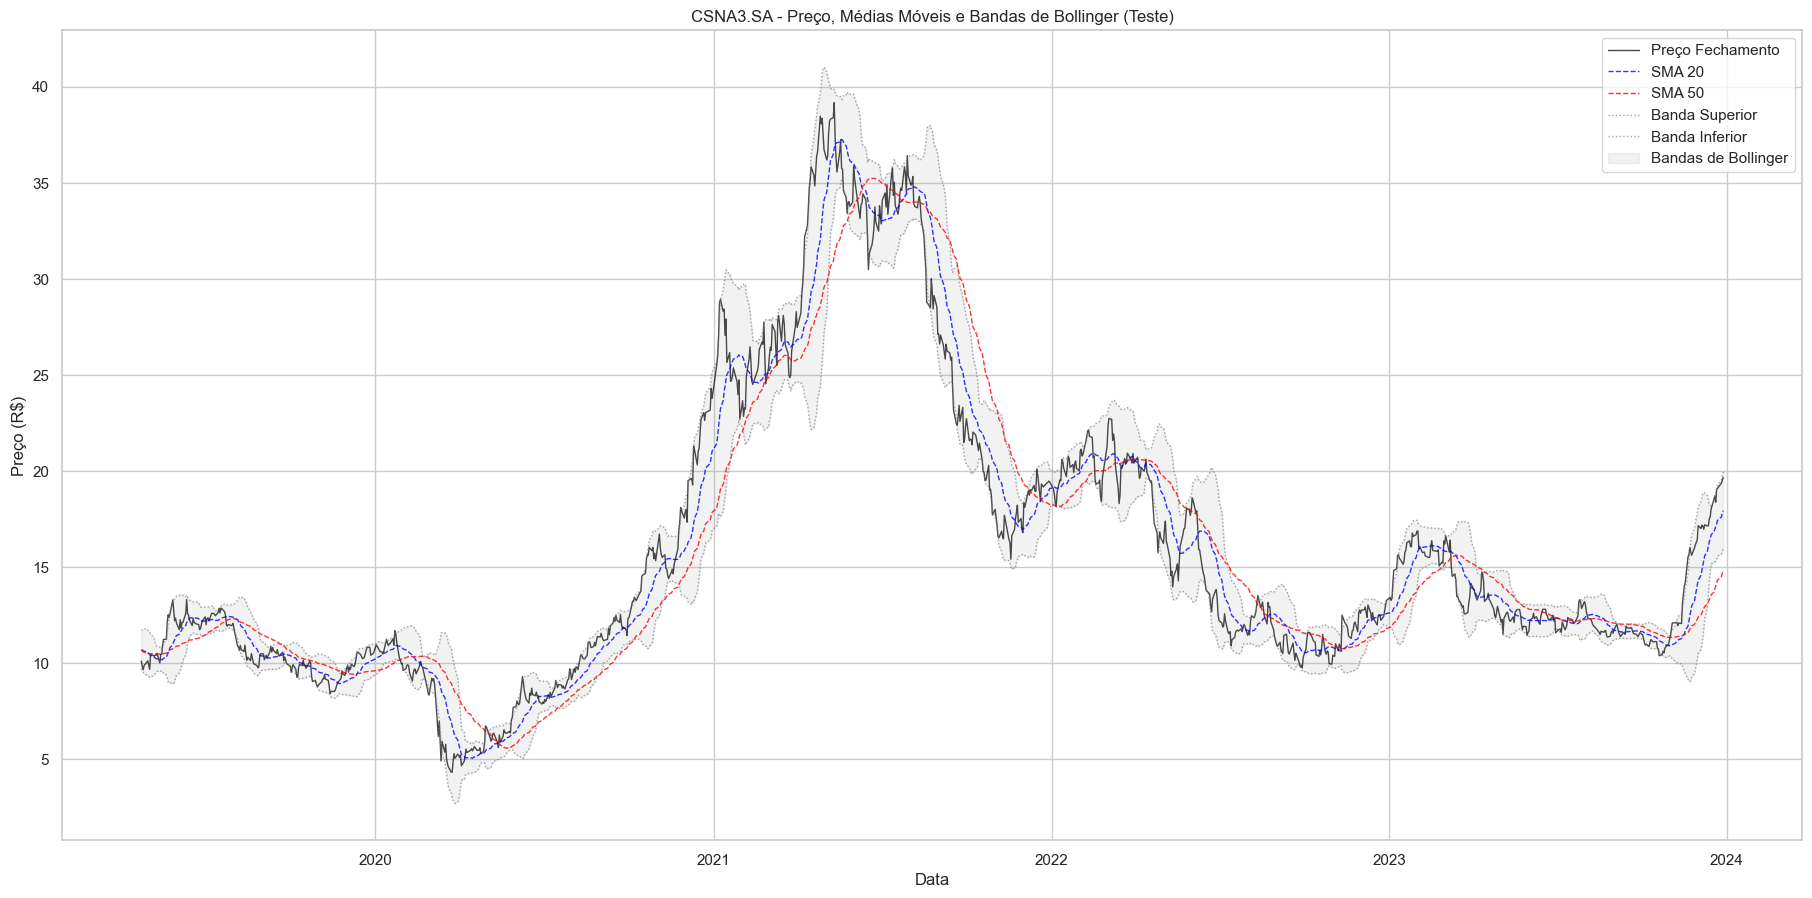


Plotando MACD e RSI (Período de Teste)...


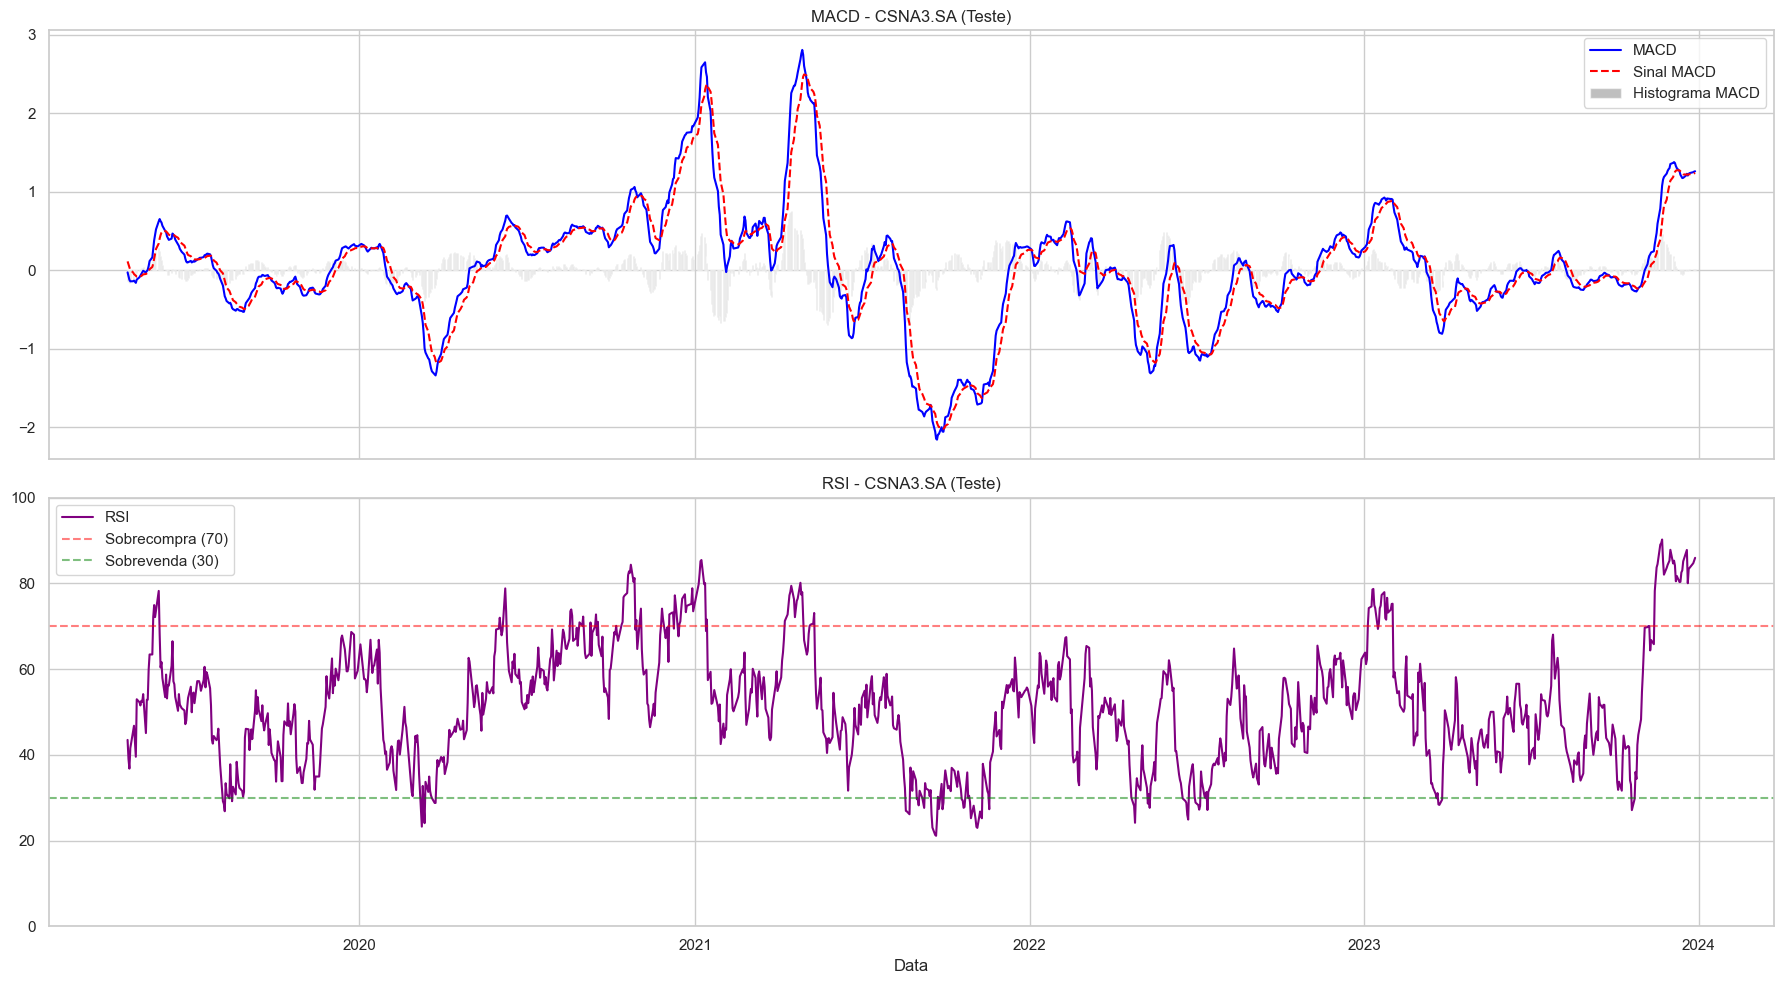

In [6]:
# Verifica se df_train e df_test existem e não estão vazios
if 'df_train' in locals() and 'df_test' in locals() and not df_train.empty and not df_test.empty:
    print("Gerando visualizações...")
    STOCK_TICKER = "CSNA3.SA" # Pega o ticker definido na célula de carregamento

    # Combinar treino e teste para visualização completa
    df_full = pd.concat([df_train, df_test])

    # 1. Preço de Fechamento ao Longo do Tempo
    plt.figure(figsize=(18, 6))
    plt.plot(df_full.index, df_full['Close'], label='Preço de Fechamento', color='royalblue', linewidth=1.5)
    plt.axvline(df_test.index.min(), color='red', linestyle='--', lw=1, label='Início do Teste')
    plt.title(f'Preço de Fechamento - {STOCK_TICKER}')
    plt.xlabel('Data')
    plt.ylabel('Preço (R$)')
    plt.legend()
    plt.show()

    # 2. Distribuição do Retorno Diário
    plt.figure(figsize=(10, 5))
    sns.histplot(df_full['daily_return'].dropna(), kde=True, bins=100)
    plt.title(f'Distribuição do Retorno Diário - {STOCK_TICKER}')
    plt.xlabel('Retorno Diário (%)')
    plt.show()

    # 3. Volatilidade Móvel (Ex: 30 dias)
    plt.figure(figsize=(18, 5))
    # Calcula volatilidade anualizada (aprox. 252 dias úteis no ano)
    volatility = df_full['daily_return'].rolling(window=30).std() * np.sqrt(252)
    plt.plot(volatility.index, volatility, label='Volatilidade Móvel (30d)', color='orange')
    plt.title(f'Volatilidade Móvel Anualizada (30 dias) - {STOCK_TICKER}')
    plt.xlabel('Data')
    plt.ylabel('Volatilidade Anualizada')
    plt.legend()
    plt.show()

    # 4. Gráfico com Indicadores Técnicos (Período de Teste)
    print("\nPlotando Preço com Médias Móveis e Bandas de Bollinger (Período de Teste)...")
    plt.figure(figsize=(20, 10))
    plt.plot(df_test.index, df_test['Close'], label='Preço Fechamento', color='black', alpha=0.7, linewidth=1)
    plt.plot(df_test.index, df_test['sma_20'], label='SMA 20', color='blue', linestyle='--', alpha=0.8, linewidth=1)
    plt.plot(df_test.index, df_test['sma_50'], label='SMA 50', color='red', linestyle='--', alpha=0.8, linewidth=1)
    plt.plot(df_test.index, df_test['bollinger_high'], label='Banda Superior', color='gray', linestyle=':', alpha=0.7, linewidth=1)
    plt.plot(df_test.index, df_test['bollinger_low'], label='Banda Inferior', color='gray', linestyle=':', alpha=0.7, linewidth=1)
    plt.fill_between(df_test.index, df_test['bollinger_low'], df_test['bollinger_high'], color='gray', alpha=0.1, label='Bandas de Bollinger')
    plt.title(f'{STOCK_TICKER} - Preço, Médias Móveis e Bandas de Bollinger (Teste)')
    plt.xlabel('Data'); plt.ylabel('Preço (R$)'); plt.legend(); plt.show()

    # 5. Gráfico MACD e RSI (Período de Teste)
    print("\nPlotando MACD e RSI (Período de Teste)...")
    fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
    axes[0].plot(df_test.index, df_test['macd'], label='MACD', color='blue')
    axes[0].plot(df_test.index, df_test['macd_signal'], label='Sinal MACD', color='red', linestyle='--')
    axes[0].bar(df_test.index, df_test['macd_hist'], label='Histograma MACD', color='gray', alpha=0.5, width=1.0) # Ajustar width se necessário
    axes[0].set_title(f'MACD - {STOCK_TICKER} (Teste)'); axes[0].legend(); axes[0].grid(True)
    axes[1].plot(df_test.index, df_test['rsi'], label='RSI', color='purple')
    axes[1].axhline(70, linestyle='--', color='red', alpha=0.5, label='Sobrecompra (70)')
    axes[1].axhline(30, linestyle='--', color='green', alpha=0.5, label='Sobrevenda (30)')
    axes[1].set_title(f'RSI - {STOCK_TICKER} (Teste)'); axes[1].set_ylim(0, 100); axes[1].legend(); axes[1].grid(True)
    plt.xlabel('Data'); plt.tight_layout(); plt.show()

else:
    print("\nDataFrames df_train ou df_test não definidos ou vazios. Visualizações não geradas.")


## 6. Análise de Correlação

Calculamos a matriz de correlação entre as features numéricas e a variável alvo (`signal`) para identificar possíveis preditores lineares. Visualizamos a matriz usando um heatmap.


Calculando matriz de correlação...

--- Correlação das Features com 'signal' (Alvo) ---
signal                       1.000000
rsi                          0.784652
return_Past_15_Days_Close    0.670612
roc_20                       0.661460
return_Past_14_Days_Close    0.661403
return_Past_13_Days_Close    0.655278
return_Past_12_Days_Close    0.648593
return_Past_11_Days_Close    0.643058
return_Past_10_Days_Close    0.633865
roc_10                       0.633865
return_Past_9_Days_Close     0.620510
return_Past_8_Days_Close     0.603556
macd                         0.582535
return_Past_7_Days_Close     0.577679
return_Past_6_Days_Close     0.543201
return_Past_5_Days_Close     0.501216
roc_5                        0.501216
macd_signal                  0.485571
macd_hist                    0.447059
return_Past_4_Days_Close     0.438204
return_Past_3_Days_Close     0.355233
return_Past_2_Days_Close     0.238426
daily_return                 0.139954
return_Past_1_Days_Close     0.139954


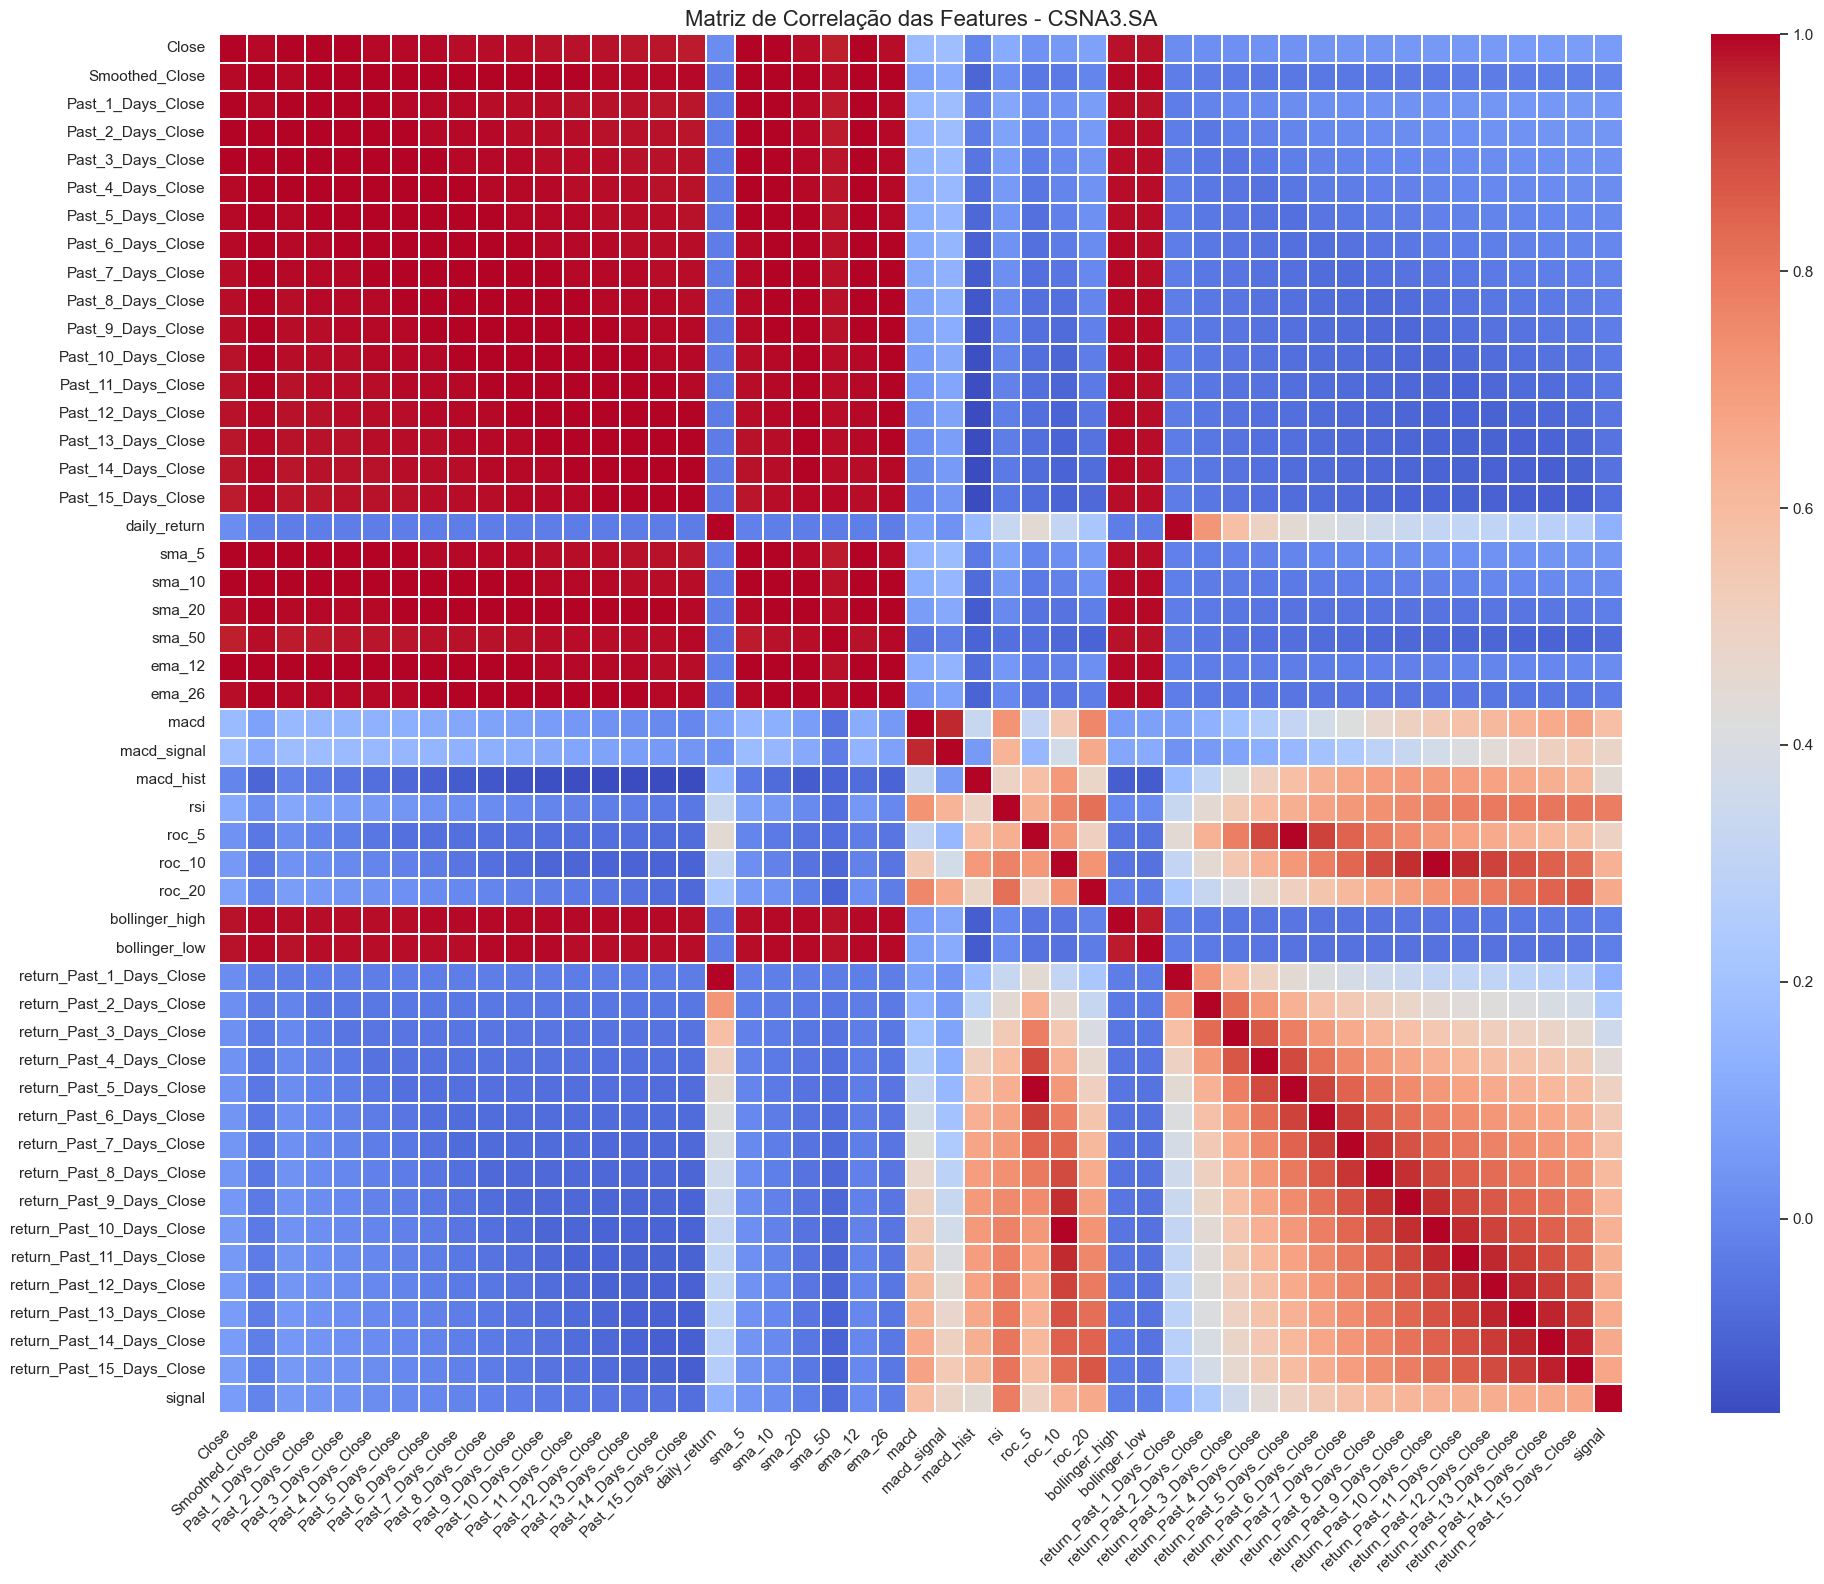

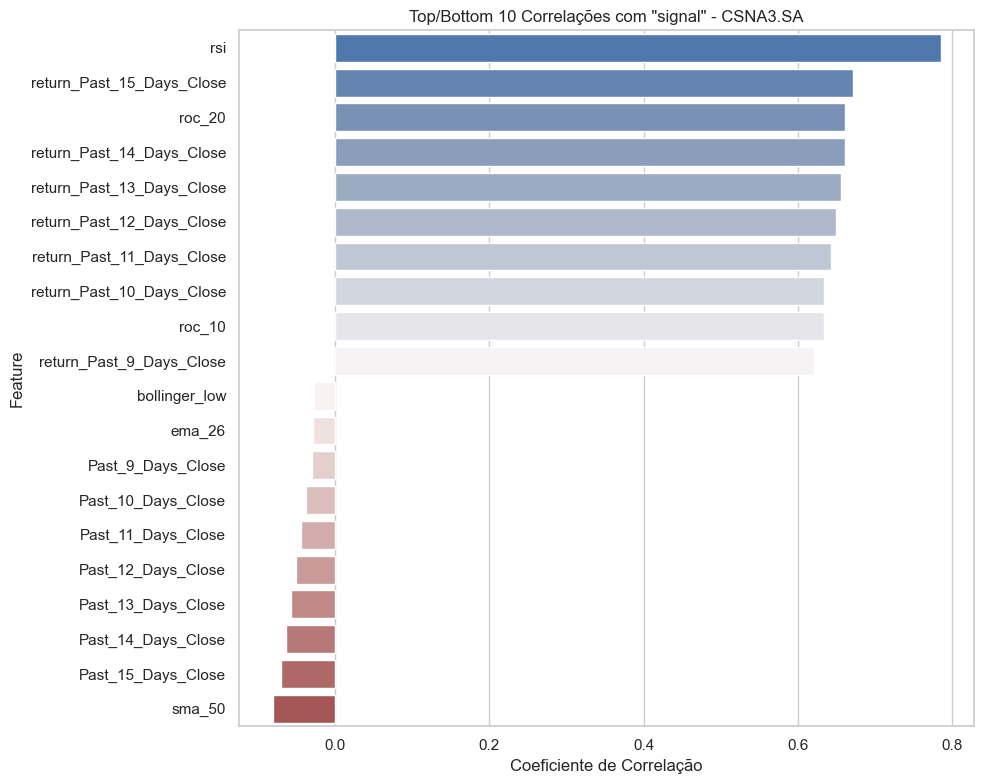

In [7]:
# Verifica se df_train existe e não está vazio
if 'df_train' in locals() and not df_train.empty:
    print("Calculando matriz de correlação...")
    # Selecionar apenas colunas numéricas
    numeric_cols = df_train.select_dtypes(include=np.number).columns.tolist()
    if 'signal' not in numeric_cols:
        print("Aviso: Coluna 'signal' não encontrada nas colunas numéricas.")
        correlation_matrix = df_train[numeric_cols].corr()
        corr_with_target = None
    else:
        correlation_matrix = df_train[numeric_cols].corr()
        corr_with_target = correlation_matrix['signal'].sort_values(ascending=False)
        print("\n--- Correlação das Features com 'signal' (Alvo) ---")
        print(corr_with_target)

    # Plotar heatmap da matriz de correlação completa
    plt.figure(figsize=(20, 16)) # Ajustar tamanho
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.2)
    plt.title(f'Matriz de Correlação das Features - {STOCK_TICKER}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Plotar apenas as correlações mais fortes com o alvo (se 'signal' existir)
    if corr_with_target is not None:
        plt.figure(figsize=(10, 8))
        n_corr = 10
        # Exclui a própria correlação do 'signal' consigo mesmo (que é 1)
        corr_subset = corr_with_target.drop('signal', errors='ignore')
        top_corr = corr_subset.head(n_corr)
        bottom_corr = corr_subset.tail(n_corr)
        # Verifica se top_corr e bottom_corr não estão vazios antes de concatenar
        if not top_corr.empty or not bottom_corr.empty:
            combined_corr = pd.concat([top_corr, bottom_corr]).sort_values(ascending=False)
            # CORREÇÃO SEABORN: Usar 'hue' e 'legend=False'
            sns.barplot(x=combined_corr.values, y=combined_corr.index, hue=combined_corr.index, palette='vlag', legend=False)
            plt.title(f'Top/Bottom {n_corr} Correlações com "signal" - {STOCK_TICKER}')
            plt.xlabel('Coeficiente de Correlação')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()
        else:
            print("Não há correlações suficientes para plotar o gráfico Top/Bottom.")

else:
    print("\nDataFrame df_train não definido ou vazio. Análise de correlação não realizada.")


## 7. Análise da Variável Alvo (`signal`)

Verificamos a distribuição da variável alvo (0 para Venda, 1 para Compra) para entender se há desbalanceamento entre as classes.


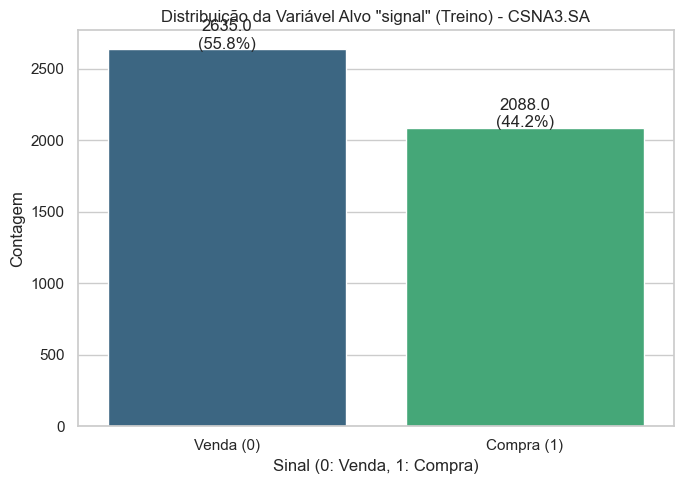


Contagem exata:
signal
0    2635
1    2088
Name: count, dtype: int64

Proporção:
signal
0    0.557908
1    0.442092
Name: proportion, dtype: float64


In [8]:
# Verifica se df_train existe e não está vazio
if 'df_train' in locals() and not df_train.empty:
    plt.figure(figsize=(7, 5))
    sns.countplot(x='signal', data=df_train, hue='signal', palette='viridis', legend=False)
    plt.title(f'Distribuição da Variável Alvo "signal" (Treino) - {STOCK_TICKER}')
    plt.xlabel('Sinal (0: Venda, 1: Compra)')
    plt.ylabel('Contagem')
    plt.xticks([0, 1], ['Venda (0)', 'Compra (1)']) # Garante labels corretos no eixo x

    # Adicionar porcentagens
    total = len(df_train)
    ax = plt.gca()
    for p in ax.patches:
        height = p.get_height()
        if height > 0: # Evita erro se uma classe não existir
            ax.text(p.get_x() + p.get_width()/2., height + 3, f'{height}\n({height/total:.1%})', ha="center")
    plt.tight_layout()
    plt.show()

    print("\nContagem exata:")
    print(df_train['signal'].value_counts())
    print("\nProporção:")
    print(df_train['signal'].value_counts(normalize=True))
else:
    print("\nDataFrame df_train não definido ou vazio. Análise do alvo não realizada.")


## 8. Conclusões Preliminares e Próximos Passos

**Conclusões da EDA para CSNA3.SA:**

* Os dados exibem características comuns a séries temporais financeiras, como volatilidade e dependência temporal.
* A engenharia de features resultou em um conjunto diversificado de indicadores técnicos (incluindo RSI, MACD, ROC, Médias Móveis e Bandas de Bollinger), potencialmente úteis para a construção de modelos preditivos.
* A análise de correlação com a variável alvo `signal` demonstra que:
    * O indicador de **momentum** `rsi` apresenta a correlação positiva mais forte (~0.78) com o sinal de compra/venda.
    * **Retornos passados** (`return_Past_X_Days_Close`), especialmente em janelas mais longas (10 a 15 dias), mostram correlações positivas elevadas (variando de ~0.63 a ~0.67), sugerindo forte poder preditivo do desempenho recente.
    * O `roc` (Rate of Change para 10 e 20 dias, com correlação ~0.63 e ~0.66 respectivamente) também está fortemente correlacionado positivamente.
    * Indicadores como `macd` (~0.58), `macd_signal` (~0.49) e `macd_hist` (~0.45) exibem correlações positivas moderadas a significativas.
    * Similarmente aos outros ativos analisados, features baseadas diretamente nos preços (`Close`, `Past_X_Days_Close`), médias móveis (`sma`, `ema`) e Bandas de Bollinger (`bollinger_high`, `bollinger_low`) apresentam correlação muito baixa com o `signal`, indicando menor relevância preditiva direta em comparação com indicadores de momentum e retorno.
* A distribuição da variável alvo `signal` é **ligeiramente desbalanceada**, com aproximadamente **55.8%** das amostras correspondendo à classe 'Venda' (0) e **44.2%** à classe 'Compra' (1). Este desbalanceamento é um fator importante a ser considerado nas etapas de modelagem e avaliação (ex: necessidade de métricas apropriadas ou técnicas de balanceamento).

**Próximos Passos:**

1.  Implementar e treinar modelos de Deep Learning (CNN 1D, LSTM, CNN-LSTM) utilizando as features preparadas para CSNA3.SA, com possível ênfase nas features de maior correlação (RSI, retornos passados, ROC).
2.  Avaliar e comparar o desempenho dos diferentes modelos para CSNA3.SA, considerando o desbalanceamento das classes ao selecionar e interpretar as métricas de avaliação.
3.  (Opcional) Realizar backtesting para simular o desempenho financeiro da estratégia de trading derivada das previsões do modelo para CSNA3.SA.
4.  (Opcional) Explorar métodos de seleção de features para refinar o conjunto de variáveis de entrada e potencialmente otimizar os modelos.
